### Faiz Ganz 
### Computer Vision Final Project

### 0) Introduction

#### Pytorch and Other Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

import torch
from torch import nn
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

#### Using GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 1) Object Detection Model (ResNet)

#### 1.1) Model Input Standardized Dimensions

In [3]:
IM_WIDTH = 128
IM_HEIGHT = 128

#### 1.2) Model Architecture (Residual Neural Network)

In [4]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):

        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1,
                          stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 16)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = torch.sigmoid(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [3, 4, 6, 3])

#### 1.3) Model Instantiation

In [5]:
model = project1_model().cuda()

#### 1.4) Model Summary

In [6]:
summary(model, (3, IM_WIDTH, IM_HEIGHT))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        1,728
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        128
├─Sequential: 1-3                        [-1, 64, 128, 128]        --
|    └─BasicBlock: 2-1                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 128, 128]        36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 128, 128]        128
|    |    └─Conv2d: 3-3                  [-1, 64, 128, 128]        36,864
|    |    └─BatchNorm2d: 3-4             [-1, 64, 128, 128]        128
|    |    └─Sequential: 3-5              [-1, 64, 128, 128]        --
|    └─BasicBlock: 2-2                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-6                  [-1, 64, 128, 128]        36,864
|    |    └─BatchNorm2d: 3-7             [-1, 64, 128, 128]        128
|    |    └─Conv2d: 3-8                  [-1, 64, 128, 128]       

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        1,728
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        128
├─Sequential: 1-3                        [-1, 64, 128, 128]        --
|    └─BasicBlock: 2-1                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 128, 128]        36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 128, 128]        128
|    |    └─Conv2d: 3-3                  [-1, 64, 128, 128]        36,864
|    |    └─BatchNorm2d: 3-4             [-1, 64, 128, 128]        128
|    |    └─Sequential: 3-5              [-1, 64, 128, 128]        --
|    └─BasicBlock: 2-2                   [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-6                  [-1, 64, 128, 128]        36,864
|    |    └─BatchNorm2d: 3-7             [-1, 64, 128, 128]        128
|    |    └─Conv2d: 3-8                  [-1, 64, 128, 128]       

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

21279044


### 2) Data

#### 2.1) Upload Images

In [8]:
image_list = os.listdir('images')

In [9]:
original_images = []
images_data = []

for image_name in image_list:
    image = cv2.imread('images/' + image_name)
    original_images += [np.array(image)]
    image = cv2.resize(image, (IM_WIDTH, IM_HEIGHT), interpolation=cv2.INTER_LINEAR)
    images_data += [np.array(image)]

images_data = np.array(images_data)

#### 2.2) Upload Targets

In [10]:
annotations_list = os.listdir('annotations')

In [11]:
import xml.etree.ElementTree as ET

targets_data = []
original_widths = []
original_heights = []

avg_width = 0
avg_height = 0

for annotation in annotations_list:
    target = []
    tree = ET.parse('annotations/' + annotation)
    root = tree.getroot()
    
    # get image sizes
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    original_widths += [width]
    original_heights += [height]
    avg_width += width
    avg_height += height
    
    # get bounds and normalize
    obj = root.find('object')
    bndbox = obj.find('bndbox')
    target = [
        int(bndbox.find('xmin').text)/width,
        int(bndbox.find('ymin').text)/height,
        int(bndbox.find('xmax').text)/width,
        int(bndbox.find('ymax').text)/height
    ]
    
    targets_data += [np.array(target)]
    
targets_data = np.array(targets_data)

avg_width /= len(annotations_list)
avg_height /= len(annotations_list)

print('Average Image Width: ', avg_width)
print('Average Image Heigth: ', avg_height)

Average Image Width:  425.1131639722864
Average Image Heigth:  292.1385681293303


#### 2.3) Display Image with Target Boundaries

In [12]:
def display_image_targets(imgs, trgts, num=5):
    
    images_data = np.copy(imgs)
    targets_data = np.copy(trgts)
    
    for i in range(num):
        sample_image = np.copy(images_data[i])
        
        xmin = int(targets_data[i][0]*IM_WIDTH)
        ymin = int(targets_data[i][1]*IM_HEIGHT)
        xmax = int(targets_data[i][2]*IM_WIDTH)
        ymax = int(targets_data[i][3]*IM_HEIGHT)
        
#         print(xmin, ymin, xmax, ymax)
        
        line_color = (255, 255, 0)
        
        sample_image = cv2.line(sample_image, (xmin, 0), (xmin, IM_HEIGHT), line_color)
        sample_image = cv2.line(sample_image, (xmax, 0), (xmax, IM_HEIGHT), line_color)
        sample_image = cv2.line(sample_image, (0, ymin), (IM_WIDTH, ymin), line_color)
        sample_image = cv2.line(sample_image, (0, ymax), (IM_WIDTH, ymax), line_color)
        
        plt.subplot(1, 5, i + 1)
        plt.imshow(sample_image)
        
    plt.show()

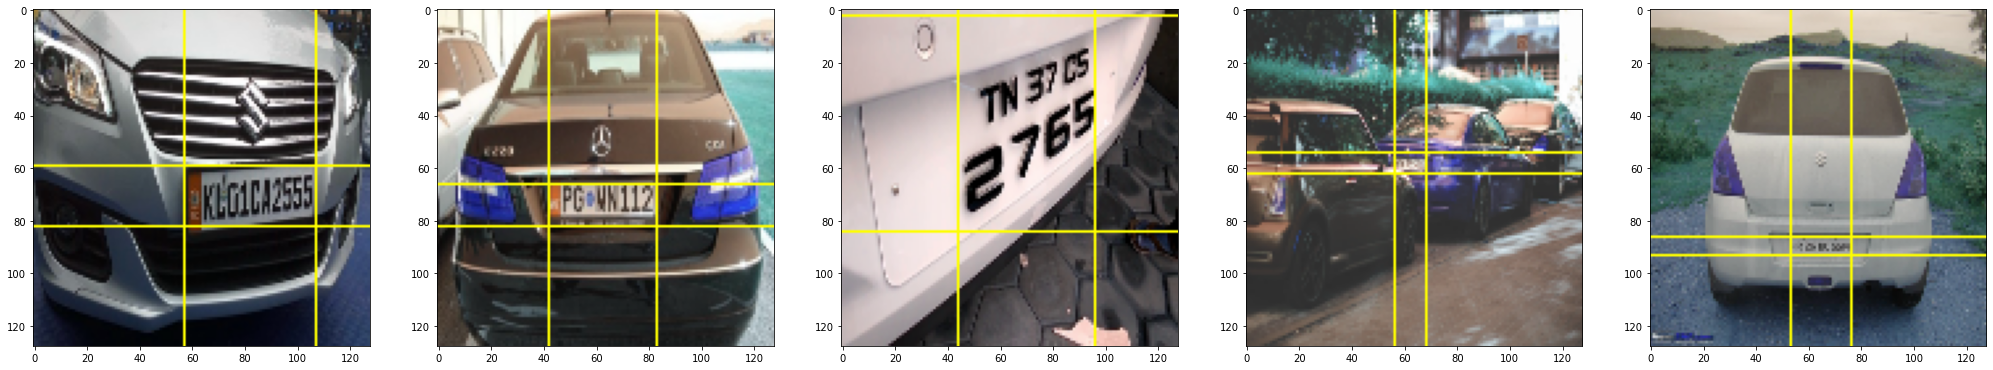

In [31]:
plt.figure(figsize=(35, 35))
display_image_targets(images_data, targets_data)

#### 2.4) Training and Test Split

In [13]:
dataset_size = 433
train_size = 400
test_size = dataset_size - train_size

train_images_data = np.copy(images_data[:train_size])
train_targets_data = np.copy(targets_data[:train_size])
test_images_data = np.copy(images_data[train_size:])
test_targets_data = np.copy(targets_data[train_size:])

#### 2.5) Augmentation: Random Translate Dataset

In [14]:
def RandomTranslate(imgs, trgts):
    translated_images_data = np.copy(imgs)
    translated_targets_data = np.copy(trgts)
    translation_vals = [-12, -9, -6, -3, 0, 3, 6, 9, 12]
#     translation_vals = [-32, -24, -16, -8, 0, 8, 16, 24, 32]
    
    for i in range(translated_images_data.shape[0]):
        translation_matrix1 = np.random.choice(translation_vals, (2,))
        M = np.float32([
            [1, 0, translation_matrix1[0]],
            [0, 1, translation_matrix1[1]]
        ])
        translated_images_data[i] = cv2.warpAffine(translated_images_data[i],
                                                  M,
                                                  (translated_images_data[i].shape[1], translated_images_data[i].shape[0]))
        
        translated_targets_data[i][0] = max(0, min(1, translated_targets_data[i][0] + (translation_matrix1[0] / IM_WIDTH)))
        translated_targets_data[i][1] = max(0, min(1, translated_targets_data[i][1] + (translation_matrix1[1] / IM_HEIGHT)))
        translated_targets_data[i][2] = max(0, min(1, translated_targets_data[i][2] + (translation_matrix1[0] / IM_WIDTH)))
        translated_targets_data[i][3] = max(0, min(1, translated_targets_data[i][3] + (translation_matrix1[1] / IM_HEIGHT)))
    
    return translated_images_data, translated_targets_data

In [15]:
aug1_imgs, aug1_trgts = RandomTranslate(train_images_data, train_targets_data)
aug2_imgs, aug2_trgts = RandomTranslate(train_images_data, train_targets_data)
aug3_imgs, aug3_trgts = RandomTranslate(train_images_data, train_targets_data)
aug4_imgs, aug4_trgts = RandomTranslate(train_images_data, train_targets_data)
aug5_imgs, aug5_trgts = RandomTranslate(train_images_data, train_targets_data)

#### 2.6) Custom Dataset Class

In [16]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, targets, images, transform=None, target_transform=None):
        self.targets = targets
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        
        image = self.images[idx]
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

#### 2.7) Augmementation and Dataset Assembly

In [17]:
standard_transform = transforms.Compose([transforms.ToTensor(),
#                                          transforms.Normalize([0.4177, 0.4200, 0.4280], [0.2887, 0.2819, 0.2837])
                                        ])

augment_transform = transforms.Compose([transforms.ToTensor(),
#                                         transforms.Normalize([0.4177, 0.4200, 0.4280], [0.2887, 0.2819, 0.2837]),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
                                       ])

In [18]:
train_dataset0 = CustomImageDataset(train_targets_data, train_images_data, standard_transform)
train_dataset1 = CustomImageDataset(aug1_trgts, aug1_imgs, augment_transform)
train_dataset2 = CustomImageDataset(aug2_trgts, aug2_imgs, augment_transform)
train_dataset3 = CustomImageDataset(aug3_trgts, aug3_imgs, augment_transform)
train_dataset4 = CustomImageDataset(aug4_trgts, aug4_imgs, augment_transform)
train_dataset5 = CustomImageDataset(aug5_trgts, aug5_imgs, augment_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dataset0,
                                                train_dataset1,
                                                train_dataset2,
                                                train_dataset3,
                                                train_dataset4,
                                                train_dataset5])

test_dataset = CustomImageDataset(test_targets_data, test_images_data, transforms.ToTensor())

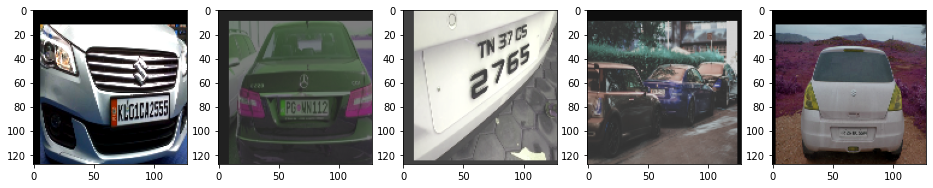

In [19]:
plt.figure(figsize=(16, 5))
for index in range(5):
    image = train_dataset1[index][0].permute(1, 2, 0)
    plt.subplot(1,5,index+1)
    plt.imshow(image.numpy())
    
plt.savefig("aug_sample.png", dpi=600)

#### 2.8) Instantiating Data Loader

In [20]:
trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

### 3) Loss, Optimizer, and Scheduler

In [21]:
import torch.optim as optim

# Loss
criterion = nn.MSELoss()

# Optimizer
lr = 0.1
momentum = 0.9
milestones = [50, 75, 90]
gamma = 0.1
weight_decay = 0.0001

optimizer = optim.SGD(
                      model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay,
                      )

scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma)

### 4) Training, Evaluation, and Visualization


#### 4.1) Train Model

In [22]:
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

EPOCHS = 100

best_accuracy = 0.0

for epoch in range(EPOCHS):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    for i, data in enumerate(trainDataLoader):
        images, targets = data
        images = images.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        output = model(images)
        fit = torch.sqrt(criterion(output.float(), targets.float()))
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        train_acc += (1.0 - fit.item())
    scheduler.step()

    model.eval()
    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, targets = data
            images = images.cuda()
            targets = targets.cuda()
            output = model(images)
            fit = torch.sqrt(criterion(output.float(), targets.float()))
            test_loss += fit.item()
            test_acc += (1.0 - fit.item())

    train_loss = train_loss / len(trainDataLoader)
    test_loss = test_loss / len(testDataLoader)
    train_loss_history += [train_loss]
    test_loss_history += [test_loss] 
    
    train_acc = train_acc / len(trainDataLoader)
    test_acc = test_acc / len(testDataLoader)
    train_acc_history += [train_acc]
    test_acc_history += [test_acc]

    print('Epoch %s, Train Loss: %s, Test Loss: %s'%(epoch + 1, np.round(train_loss, 5), np.round(test_loss, 5)))

Epoch 1, Train Loss: 0.21396, Test Loss: 0.14364
Epoch 2, Train Loss: 0.1894, Test Loss: 0.16262
Epoch 3, Train Loss: 0.1781, Test Loss: 0.1405
Epoch 4, Train Loss: 0.17117, Test Loss: 0.15217
Epoch 5, Train Loss: 0.1671, Test Loss: 0.13766
Epoch 6, Train Loss: 0.16158, Test Loss: 0.14151
Epoch 7, Train Loss: 0.15967, Test Loss: 0.13318
Epoch 8, Train Loss: 0.15303, Test Loss: 0.12549
Epoch 9, Train Loss: 0.15208, Test Loss: 0.15705
Epoch 10, Train Loss: 0.14475, Test Loss: 0.15753
Epoch 11, Train Loss: 0.14785, Test Loss: 0.13802
Epoch 12, Train Loss: 0.14017, Test Loss: 0.15405
Epoch 13, Train Loss: 0.13732, Test Loss: 0.14243
Epoch 14, Train Loss: 0.13182, Test Loss: 0.1354
Epoch 15, Train Loss: 0.12982, Test Loss: 0.19208
Epoch 16, Train Loss: 0.1225, Test Loss: 0.18364
Epoch 17, Train Loss: 0.11442, Test Loss: 0.22024
Epoch 18, Train Loss: 0.10079, Test Loss: 0.12138
Epoch 19, Train Loss: 0.1037, Test Loss: 0.14847
Epoch 20, Train Loss: 0.09377, Test Loss: 0.16173
Epoch 21, Train 

#### 4.2) Performance Plots

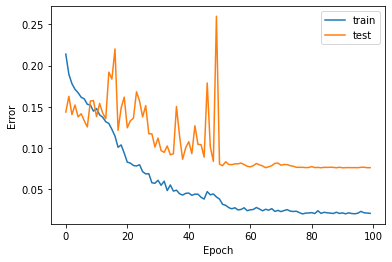

In [23]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.legend(["train", "test"])
plt.xlabel("Epoch")
plt.ylabel("Error")

plt.savefig('error.png', dpi=600)

Text(0, 0.5, 'Accuracy')

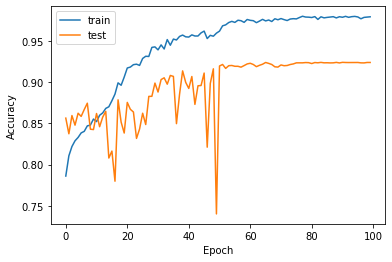

In [24]:
plt.plot(train_acc_history)
plt.plot(test_acc_history)
plt.legend(["train", "test"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")



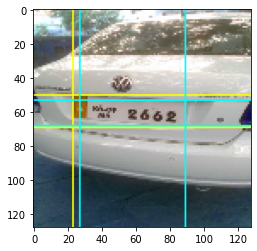

In [32]:
# plt.figure(figsize=(15, 40))

original_test_image = original_images[train_size:]

for i, data in enumerate(testDataLoader):
    with torch.no_grad():
        images, targets = data
        images = images.cuda()
        targets = targets.cuda()
        output = model(images)
        
        targets_vals = targets.cpu().numpy()[0]
        output_vals = output.cpu().numpy()[0] 
        
        test_image = np.transpose(images.cpu().numpy()[0], (1, 2, 0)).copy()
        test_image = (test_image * 255).astype('int')
        
        xmin = int(targets_vals[0]*IM_WIDTH)
        ymin = int(targets_vals[1]*IM_HEIGHT)
        xmax = int(targets_vals[2]*IM_WIDTH)
        ymax = int(targets_vals[3]*IM_HEIGHT)
        
        line_color = (255, 255, 0)
        
        test_image = cv2.line(test_image, (xmin, 0), (xmin, IM_HEIGHT), line_color)
        test_image = cv2.line(test_image, (xmax, 0), (xmax, IM_HEIGHT), line_color)
        test_image = cv2.line(test_image, (0, ymin), (IM_WIDTH, ymin), line_color)
        test_image = cv2.line(test_image, (0, ymax), (IM_WIDTH, ymax), line_color)
        
        xmin = int(output_vals[0]*IM_WIDTH)
        ymin = int(output_vals[1]*IM_HEIGHT)
        xmax = int(output_vals[2]*IM_WIDTH)
        ymax = int(output_vals[3]*IM_HEIGHT)
        
        line_color = (0, 255, 255)
        
        test_image = cv2.line(test_image, (xmin, 0), (xmin, IM_HEIGHT), line_color)
        test_image = cv2.line(test_image, (xmax, 0), (xmax, IM_HEIGHT), line_color)
        test_image = cv2.line(test_image, (0, ymin), (IM_WIDTH, ymin), line_color)
        test_image = cv2.line(test_image, (0, ymax), (IM_WIDTH, ymax), line_color)
        
#         plt.subplot(11, 3, i+1)
        plt.imshow(test_image)
        plt.savefig('results34/res' + str(i) + '.png', dpi=600)

In [33]:
torch.save(model.state_dict(), 'resnet34.pt')